In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
# %cd "/content/gdrive/MyDrive/pytorch-AdaIN"

Mounted at /content/gdrive
/content/gdrive/MyDrive/pytorch-AdaIN


In [4]:
import os
# path = '/content/gdrive/MyDrive/pytorch-AdaIN'
# os.mkdir(path)

In [5]:
os.chdir("/content/gdrive/MyDrive/pytorch-AdaIN")

In [6]:
!git clone https://github.com/naoto0804/pytorch-AdaIN

Cloning into 'pytorch-AdaIN'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 323 (delta 62), reused 64 (delta 59), pack-reused 248
Receiving objects: 100% (323/323), 7.79 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (160/160), done.


In [17]:
import os
os.mkdir('models/')

In [18]:
!ls

function.py  models	  README.md	    sampler.py	   torch_to_pytorch.py
input	     net.py	  requirements.txt  test.py	   train.py
LICENSE      __pycache__  results.png	    test_video.py


In [6]:
import cv2
import numpy as np
import torch
from PIL import Image

from net import vgg, decoder
from function import adaptive_instance_normalization, coral

In [20]:
class StyleTransfer:

  def __init__(self):

    vgg_enc = vgg
    vgg_dec = decoder
    vgg_enc.load_state_dict(torch.load("models/vgg_normalised.pth"))
    vgg_dec.load_state_dict(torch.load("models/decoder.pth"))

    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.vgg_enc = vgg_enc[:31].to(self.device)
    self.vgg_dec = vgg_dec.to(self.device)

    self.vgg_enc.eval()
    self.vgg_dec.eval()

  def run(self, content_img, style_img, alpha=1.0, preserve_color=True):

    content_img = torch.FloatTensor(content_img).permute(2,0,1)
    style_img = torch.FloatTensor(style_img).permute(2,0,1)

    if preserve_color:
      style_img = coral(style_img, content_img)

    content_img = content_img.unsqueeze(0).to(self.device)
    style_img = style_img.unsqueeze(0).to(self.device)

    with torch.no_grad():
      content_feat = self.vgg_enc(content_img)
      style_feat = self.vgg_enc(style_img)
      new_feat = adaptive_instance_normalization(content_feat, style_feat)
      new_feat = alpha*new_feat + (1-alpha)*content_feat
      new_img = self.vgg_dec(new_feat)

    return new_img.squeeze(0).cpu()

In [21]:
def show_img(img):

  img = img.permute(1,2,0).numpy()
  img = 255*(img-img.max()) / (img.max()-img.min())
  img = Image.fromarray(img.astype("uint8"))
  display(img)

In [22]:
model = StyleTransfer()

In [28]:
content_img = cv2.imread("input/content/golden_gate.jpg")
style_img = cv2.imread("input/style/sketch.png")

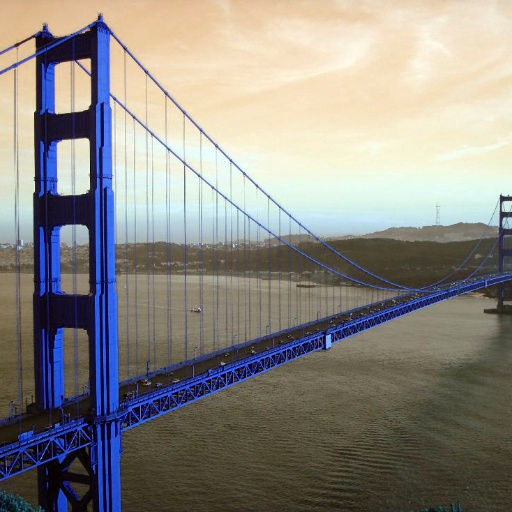

In [29]:
display(Image.fromarray(content_img))

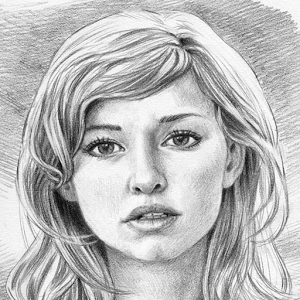

In [30]:
display(Image.fromarray(style_img))

In [31]:
new_img = model.run(content_img, style_img, alpha=1)

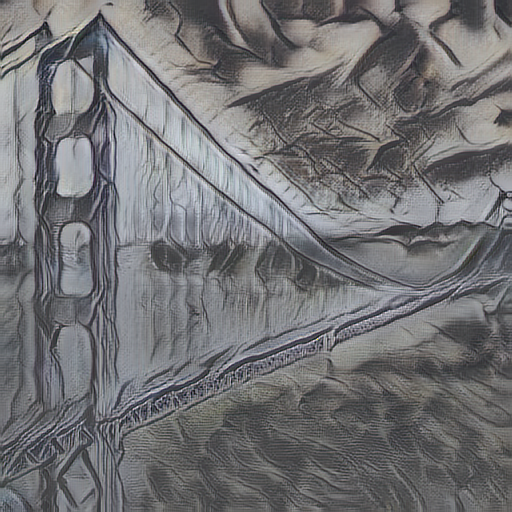

In [32]:
show_img(new_img)